## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [2]:
df = pd.read_csv("../Datasets/Lower player.csv")

In [3]:
df.shape

(5912, 19)

In [4]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,1,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000
1,2,Manchester United,Goalkeeper,188.0,37.0,4,0.0,0.0,0.000000,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000


In [5]:
df.drop(columns='Unnamed: 0' , inplace = True)
# df.drop(columns='name' , inplace = True)

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [6]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [7]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [8]:
numeric_col = [col for col in df.columns if df[col].dtype != "object"]
categorical_col = [col for col in df.columns if df[col].dtype == "object"]

In [9]:
# for i in categorical_col:
#     print(df[i].value_counts())

In [10]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['sale_price_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['sale_price_category'].value_counts())

sale_price_category
Good_Price     2255
Cheap_Price    1946
High_Price     1711
Name: count, dtype: int64


In [11]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,highest_value,sale_price_category
0,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,22000000,High_Price
1,Manchester United,Goalkeeper,188.0,37.0,4,0.0,0.0,0.000000,0.0,0.0,0.616438,0.924658,292,697,84,4,6000000,Good_Price


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [12]:
categorical_col = ['team' , 'position']

In [13]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_col)

In [14]:
df.shape

(5912, 403)

In [15]:
encoder = LabelEncoder()
df['sale_price_category'] = encoder.fit_transform(df['sale_price_category'])  

#### 3. Feature selection

In [16]:
correlation = df.corr()
correlation['sale_price_category'].sort_values(ascending=False)

sale_price_category    1.000000
highest_value          0.381909
minutes played         0.306681
appearance             0.305590
games_injured          0.233946
                         ...   
position_Defender     -0.090184
position_Attack       -0.115159
position_midfield     -0.133761
goals conceded        -0.143927
position_Goalkeeper   -0.209644
Name: sale_price_category, Length: 403, dtype: float64

In [17]:
# Set the correlation threshold
threshold = 0.1  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['sale_price_category']) > threshold]['sale_price_category'].index
selected_features

Index(['age', 'appearance', 'assists', 'goals conceded', 'minutes played',
       'days_injured', 'games_injured', 'award', 'highest_value',
       'sale_price_category', 'position_Attack', 'position_Goalkeeper',
       'position_midfield'],
      dtype='object')

In [18]:
df = df[selected_features]

#### 4. Prepare train and test data

In [19]:
# Prepare data
X = df.drop(['sale_price_category'], axis=1)
y = df['sale_price_category']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
X.shape

(5912, 12)

## Buliding the Model

In [21]:
model = LogisticRegression()

## Train the Model

In [22]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

## Test the Model

In [23]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Interpretation of the Model

In [24]:
model.coef_

array([[ 8.53156995e-02,  8.74620011e-02, -3.54741231e-02,
         5.04587128e-02, -4.40325859e-01, -3.03941511e-02,
        -5.66202985e-02,  5.62795767e-02, -3.26965253e+00,
         4.81313927e-01,  2.19620032e-01,  3.35568015e-01],
       [ 2.89344432e-01,  1.31861840e-01, -3.36279679e-02,
         4.80817888e-02,  4.82392075e-02, -1.13227311e-01,
         2.86037021e-01, -3.02930003e-04,  9.71171003e-02,
        -2.58440601e-01, -6.94582927e-02,  1.53551074e-02],
       [-3.74660131e-01, -2.19323841e-01,  6.91020909e-02,
        -9.85405016e-02,  3.92086652e-01,  1.43621462e-01,
        -2.29416723e-01, -5.59766467e-02,  3.17253543e+00,
        -2.22873325e-01, -1.50161740e-01, -3.50923122e-01]])

In [25]:
print(model.intercept_) 

[-0.73069082  0.4976939   0.23299692]


## Evaluating the Model 

In [26]:
# our benchmark model
base_model = round(df['sale_price_category'].value_counts()[1]/df.shape[0]*100, 2)
base_model

38.14

1. Accuracy

In [27]:
# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred)
print('Test Accuracy' ,accuracy_test*100)

y_pred_train = model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Train Accuracy' ,accuracy_train*100)

Test Accuracy 67.6246830092984
Train Accuracy 67.35039120321422


2. Precision

In [28]:
# Calculate Precision
precision_test = precision_score(y_test, y_pred, average='macro')
print("Test Precision:" ,precision_test*100)

y_pred_train = model.predict(X_train_scaled)
precision_train = precision_score(y_train, y_pred_train, average='macro')
print('Train Precision:' ,precision_train*100)

Test Precision: 70.71072916182779
Train Precision: 70.62427964943619


3. Recall

In [29]:
# Calculate Recall
recall_test = recall_score(y_test, y_pred, average='macro')
print("Test Recall:" , recall_test*100)

y_pred_train = model.predict(X_train_scaled)
recall_train = precision_score(y_train, y_pred_train, average='macro')
print('Train Recall:' ,recall_train*100)

Test Recall: 67.48456147620197
Train Recall: 70.62427964943619


4. F1 Score

In [30]:
# Calculate F1 Score
f1_test = f1_score(y_test, y_pred, average='macro')
print("Test F1 Score:" , f1_test*100)

y_pred_train = model.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print('Train Recall:' ,f1_train*100)

Test F1 Score: 68.33610122048009
Train Recall: 68.18540470090115


#### Predictions vs. Real Values

In [31]:
predictions = model.predict(X_test_scaled)

In [32]:
Real_Values = np.array(y_test)
#Real_Values

#### Residual Histogram

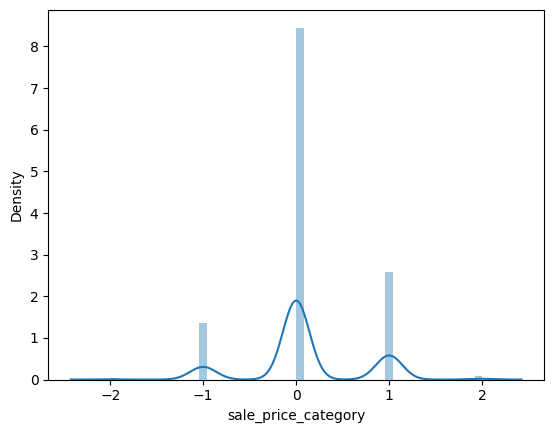

In [33]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

In [34]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[292,  93,   3],
       [118, 296,  35],
       [  8, 126, 212]], dtype=int64)